In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import chugunov_indicator as chug

In [2]:
data = chug.DetonationData("./data/subch_plt08582/")

yt : [INFO     ] 2024-09-20 02:06:20,415 Parameters: current_time              = 0.40003216130915
yt : [INFO     ] 2024-09-20 02:06:20,416 Parameters: domain_dimensions         = [ 640 1280    1]
yt : [INFO     ] 2024-09-20 02:06:20,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-20 02:06:20,418 Parameters: domain_right_edge         = [5.12000000e+09 1.02400000e+10 6.28318531e+00]


In [3]:
T, D = data.D_T_meshgrid()

In [4]:
i = 500
kwargs = {
    "abar": data.data["abar"][i],
    "zbar": data.data["zbar"][i],
    "z2bar": data.data["z2bar"][i],
    **data.data["ScreenFactors"][1]
}
kwargs

{'abar': 4.028776983649797,
 'zbar': 2.0143884920095214,
 'z2bar': 4.129496456710949,
 'z1': 2,
 'a1': 4,
 'z2': 6,
 'a2': 12}

In [5]:
F = chug.chugunov_2009(T, D, **kwargs)

In [6]:
T_border, D_border = chug.fitting.border_from_grid(T, D, F, percent=0.99875)

Let's make the assumption $k = 3$, that is, the border line is really a cubic curve $\rho \propto T^3$.

In [7]:
c, var_c = chug.parameters_from_border(T_border, D_border, return_pcov=True)

In [8]:
display(c, np.sqrt(var_c))

22.699200488731986

0.0030385189709732476

Since $\sigma_c \ll c$ (which holds in general), we can neglect uncertainties from here on out.

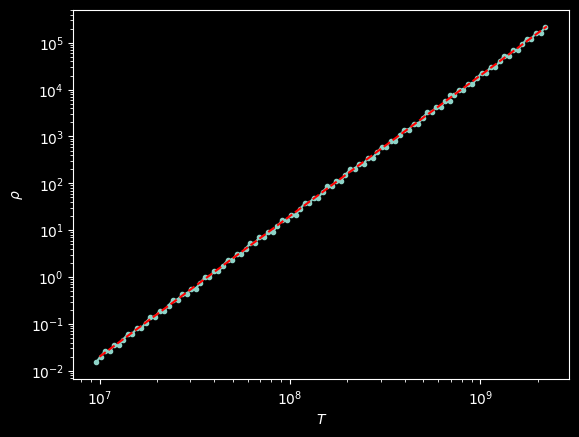

In [9]:
fig1, ax1 = plt.subplots()

chug.D_T_setup(ax1)

ax1.plot(T_border, D_border, marker=".")
T_ = np.logspace(7, 9.35)
D_ = chug.border_func(T_, c)

line, = ax1.plot(T_, D_, color="red", linestyle="--")

In [10]:
data.data["ScreenFactors"]

[{'z1': 1, 'a1': 1, 'z2': 6, 'a2': 12},
 {'z1': 2, 'a1': 4, 'z2': 6, 'a2': 12},
 {'z1': 2, 'a1': 4, 'z2': 7, 'a2': 14},
 {'z1': 2, 'a1': 4, 'z2': 8, 'a2': 16},
 {'z1': 2, 'a1': 4, 'z2': 9, 'a2': 18},
 {'z1': 2, 'a1': 4, 'z2': 10, 'a2': 20},
 {'z1': 1, 'a1': 1, 'z2': 10, 'a2': 21},
 {'z1': 1, 'a1': 1, 'z2': 11, 'a2': 23},
 {'z1': 2, 'a1': 4, 'z2': 11, 'a2': 23},
 {'z1': 2, 'a1': 4, 'z2': 12, 'a2': 24},
 {'z1': 1, 'a1': 1, 'z2': 13, 'a2': 27},
 {'z1': 2, 'a1': 4, 'z2': 13, 'a2': 27},
 {'z1': 2, 'a1': 4, 'z2': 14, 'a2': 28},
 {'z1': 1, 'a1': 1, 'z2': 15, 'a2': 31},
 {'z1': 2, 'a1': 4, 'z2': 16, 'a2': 32},
 {'z1': 2, 'a1': 4, 'z2': 18, 'a2': 36},
 {'z1': 2, 'a1': 4, 'z2': 20, 'a2': 40},
 {'z1': 2, 'a1': 4, 'z2': 22, 'a2': 44},
 {'z1': 2, 'a1': 4, 'z2': 24, 'a2': 48},
 {'z1': 2, 'a1': 4, 'z2': 26, 'a2': 52},
 {'z1': 6, 'a1': 12, 'z2': 6, 'a2': 12},
 {'z1': 2, 'a1': 4, 'z2': 7, 'a2': 13},
 {'z1': 1, 'a1': 1, 'z2': 8, 'a2': 16},
 {'z1': 6, 'a1': 12, 'z2': 8, 'a2': 16},
 {'z1': 8, 'a1': 16, 'z

In [11]:
variance = data.data["z2bar"] - data.data["zbar"]**2
variance.min(), variance.max()

(0.07173538122272038, 163.844288919927)

In [134]:
minmax = {
    "abar": (data.data["abar"].min(), data.data["abar"].max()),
    "zbar": (data.data["zbar"].min(), data.data["zbar"].max()),
    "z2bar": (data.data["z2bar"].min(), data.data["z2bar"].max()),
    "z1": (1, 10),
    "z2": (1, 10)
}

minmax

{'abar': (4.028776676342192, 52.43965444432472),
 'zbar': (2.0143883383557393, 26.223830930940498),
 'z2bar': (4.1294958073363555, 713.3104742534674),
 'z1': (1, 10),
 'z2': (1, 10)}

In [13]:
key_line = "zbar"

new_data = {**kwargs}
if key_line == "zbar":
    new_data[key_line] = np.linspace(1, 700, 700*2)
else:
    new_data[key_line] = np.linspace(1, 70, 70*5)

x = new_data[key_line]

In [14]:
C = chug.parameters_from_vars(T=T, D=D, **new_data)

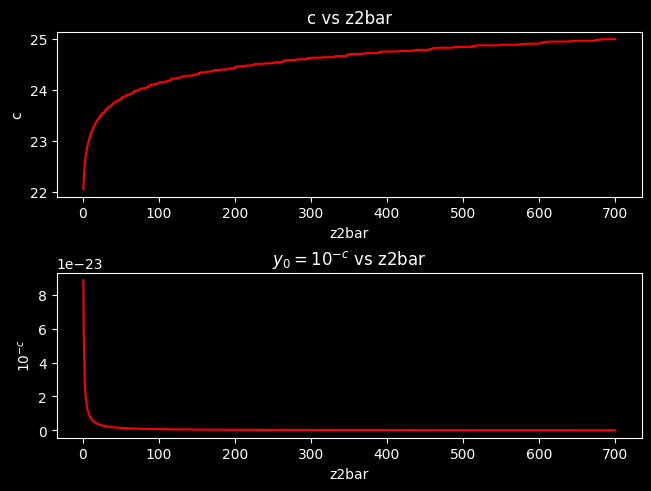

In [16]:
fig2, ax2 = plt.subplots(2, 1, constrained_layout=True)

ax2[0].set_title("c vs " + key_line)
ax2[0].set_xlabel(key_line)
ax2[0].set_ylabel("c")

ax2[1].set_title("$y_0 = 10^{-c}$ vs " + key_line)
ax2[1].set_xlabel(key_line)
ax2[1].set_ylabel("$10^{-c}$")

#ax2[2].set_title("y_0' vs " + key_line)
#ax2[2].set_title("c' vs " + key_line)
#ax2[2].set_xlabel(key_line)
#ax2[2].set_ylabel("c")

ax2[0].plot(x, C, color="red")
ax2[1].plot(x, 1/10**C, color="red")

#ax2[2].plot(x, dC_dvar, color="red")
#ax2[2].plot(x, dC_dvar * - np.log(10) * 1/10**C, color="red")

if key_line == "abar":
    ax2[1].plot(x, 2e-22/40 * x, linestyle="--", color="yellow")
#elif key_line in ("z1", "z2"):
#    ax2[0].plot(x, 31 - 8*np.exp(-np.sqrt(x)/20))